In [0]:
%pip install tensorflow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
!pip install mlflow
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#import joblib


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# File location and type
file_location = "/FileStore/tables/datafinal-3.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)


In [0]:
import pandas as pd
df = df2.toPandas()


In [0]:
df.drop(df.columns[[1]], axis=1, inplace=True)
df.head()

,periodo,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
0,20194,SB11201940323382,URBANO,N,A,TÉCNICO/ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,62265,VALLE,MIXTO,MAÑANA,CALI,NO OFICIAL,LIC MODERNO CIUDAD DE CALI,LIC MODERNO CIUDAD DE CALI,S,76,76001,76,76001,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2003-07-12,M,CALI,CALI,COLOMBIA,COLOMBIA,N,Tres,Secundaria (Bachillerato) completa,Primaria incompleta,Estrato 2,3 a 4,No,No,No,Si,A-,36,42,27,38,41,185
1,20194,SB11201940323382,URBANO,N,A,TÉCNICO/ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,62265,VALLE,MIXTO,MAÑANA,CALI,NO OFICIAL,LIC MODERNO CIUDAD DE CALI,LIC MODERNO CIUDAD DE CALI,S,76,76001,76,76001,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2003-07-12,M,CALI,CALI,COLOMBIA,COLOMBIA,N,Tres,Secundaria (Bachillerato) completa,Primaria incompleta,Estrato 2,3 a 4,No,No,No,Si,A-,36,42,27,38,41,185
2,20194,SB11201940559593,URBANO,N,A,TÉCNICO/ACADÉMICO,1.760000e+11,1.760000e+11,76,76147,24364,VALLE,MIXTO,TARDE,CARTAGO,OFICIAL,ACADEMICO,NACIONAL ACADEMICO,S,76,76147,76,76147,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2001-01-19,F,CARTAGO,CARTAGO,COLOMBIA,COLOMBIA,N,Cuatro,Primaria incompleta,Primaria incompleta,Estrato 2,7 a 8,No,Si,Si,Si,A-,42,56,60,49,65,282
3,20194,SB11201940559593,URBANO,N,A,TÉCNICO/ACADÉMICO,1.760000e+11,1.760000e+11,76,76147,24364,VALLE,MIXTO,TARDE,CARTAGO,OFICIAL,ACADEMICO,NACIONAL ACADEMICO,S,76,76147,76,76147,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2001-01-19,F,CARTAGO,CARTAGO,COLOMBIA,COLOMBIA,N,Cuatro,Primaria incompleta,Primaria incompleta,Estrato 2,7 a 8,No,Si,Si,Si,A-,42,56,60,49,65,282
4,20194,SB11201940404833,URBANO,N,A,TÉCNICO,1.770000e+11,1.770000e+11,76,76520,58776,VALLE,MIXTO,TARDE,PALMIRA,OFICIAL,INSTITUCION EDUCATIVA SAN VICENTE,IE SAN VICENTE,S,76,76520,76,76520,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2002-07-10,F,PALMIRA,PALMIRA,COLOMBIA,COLOMBIA,N,Dos,Educación profesional completa,Educación profesional completa,Estrato 2,3 a 4,Si,Si,Si,Si,B1,70,66,71,66,66,337


In [0]:
df['clasificacion'] = df['punt_global'].apply(lambda x: 1 if x > 320 else 0)

In [0]:
df_1=df[df['clasificacion']==1]
df_0=df[df['clasificacion']==0]

In [0]:
#Filas para la muestra que sean las que tienen 1
n_1=len(df_1)
#Muestrear ese numero de filas con clasificación = 0
df_0_sample =df_0.sample(n=n_1, random_state=42)
#Combinar los subconjuntos
df_balanced =pd.concat([df_1,df_0_sample])
#Mezclar ell dataframe resultante
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['clasificacion'].value_counts())
df_balanced.head()

1    16962
0    16962
Name: clasificacion, dtype: int64


,periodo,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global,clasificacion
0,20191,SB11201910028535,URBANO,N,B,ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,16691,VALLE,MIXTO,COMPLETA,CALI,NO OFICIAL,COLEGIO AMERICANO,COLEGIO AMERICANO,S,76,76001,76,76001,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2002-05-25,F,CALI,CALI,COLOMBIA,COLOMBIA,N,Tres,Educación profesional completa,Educación profesional completa,Estrato 4,3 a 4,Si,Si,Si,Si,B+,80,62,65,67,71,337,1
1,20194,SB11201940529895,URBANO,N,A,ACADÉMICO,1.760000e+11,1.760000e+11,76,76041,152173,VALLE,MIXTO,SABATINA,ANSERMANUEVO,OFICIAL,INSTITUCION EDUCATIVA SANTA ANA DE LOS CABALLEROS,SANTA ANA DE LOS CABALLEROS,S,76,76041,76,76041,VALLE,VALLE,PUBLICAR,ESTUDIANTE,1981-09-19,F,ANSERMANUEVO,ANSERMANUEVO,COLOMBIA,COLOMBIA,N,Dos,Primaria incompleta,Ninguno,Estrato 2,7 a 8,No,Si,Si,No,A-,41,31,33,34,29,162,0
2,20194,SB11201940295505,URBANO,N,A,TÉCNICO/ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,111393,VALLE,MIXTO,MAÑANA,CALI,NO OFICIAL,COLEGIO ARQUIDIOCESANO JUAN PABLO II,COL ARQUID. JUAN PABLO II,S,76,76001,76,76001,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2002-03-31,F,CALI,CALI,COLOMBIA,COLOMBIA,N,Dos,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) incompleta,Estrato 2,3 a 4,Si,Si,Si,Si,A1,49,53,55,53,43,254,0
3,20194,SB11201940085160,URBANO,N,A,TÉCNICO/ACADÉMICO,1.760000e+11,1.760000e+11,76,76001,65961,VALLE,MIXTO,TARDE,CALI,OFICIAL,INSTITUCION EDUCATIVA LIBARDO MADRID VALDERRAMAMA,INSTITUCION EDUCATIVA LIBARDO MADRID VALDERRAM...,S,76,76001,76,76001,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2002-12-30,F,CALI,CALI,COLOMBIA,COLOMBIA,N,Dos,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,Estrato 2,3 a 4,Si,Si,Si,Si,A-,40,48,52,51,53,251,0
4,20224,SB11202240101999,URBANO,N,A,TÉCNICO/ACADÉMICO,1.770000e+11,1.770000e+11,76,76520,118414,VALLE,MIXTO,MAÑANA,PALMIRA,OFICIAL,INSTITUCION EDUCATIVA JUAN PABLO II,JUAN PABLO II,S,76,76520,76,76520,VALLE,VALLE,PUBLICAR,ESTUDIANTE,2005-06-23,M,PALMIRA,PALMIRA,COLOMBIA,COLOMBIA,N,Dos,Secundaria (Bachillerato) completa,Primaria incompleta,Estrato 1,3 a 4,No,No,Si,Si,A-,38,59,50,40,46,240,0


In [0]:
X = df_balanced[['fami_tienecomputador','cole_bilingue','cole_area_ubicacion','estu_genero','fami_estratovivienda',
        'cole_naturaleza','fami_tieneinternet','fami_educacionpadre','fami_educacionmadre']]
y = df_balanced["clasificacion"]

In [0]:
X

,fami_tienecomputador,cole_bilingue,cole_area_ubicacion,estu_genero,fami_estratovivienda,cole_naturaleza,fami_tieneinternet,fami_educacionpadre,fami_educacionmadre
0,Si,N,URBANO,F,Estrato 4,NO OFICIAL,Si,Educación profesional completa,Educación profesional completa
1,Si,N,URBANO,F,Estrato 2,OFICIAL,Si,Ninguno,Primaria incompleta
2,Si,N,URBANO,F,Estrato 2,NO OFICIAL,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa
3,Si,N,URBANO,F,Estrato 2,OFICIAL,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa
4,No,N,URBANO,M,Estrato 1,OFICIAL,Si,Primaria incompleta,Secundaria (Bachillerato) completa
...,...,...,...,...,...,...,...,...,...
33919,No,N,URBANO,F,Estrato 1,OFICIAL,Si,Primaria completa,Primaria incompleta
33920,Si,N,URBANO,M,Estrato 2,OFICIAL,Si,No sabe,Educación profesional completa
33921,Si,S,RURAL,M,Estrato 6,NO OFICIAL,Si,Postgrado,Postgrado
33922,Si,N,URBANO,M,Estrato 3,OFICIAL,No,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa


## Entrenamiento de Datos

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42)

In [0]:
categorical_features = ['fami_tienecomputador','cole_bilingue','cole_area_ubicacion','estu_genero','fami_estratovivienda','cole_naturaleza','fami_tieneinternet','fami_educacionpadre','fami_educacionmadre']


In [0]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [0]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Crear un pipeline que incluya el preprocesamiento y el modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [0]:
pipeline.fit(X_train)

/databricks/python/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['fami_tienecomputador',
                                                   'cole_bilingue',
                                                   'cole_area_ubicacion',
                                                   'estu_genero',
                                                   'fami_estratovivienda',
                                                   'cole_naturaleza',
                                                   'fami_tieneinternet',
                                                   'fami_educacionpadre',
                                                   'fami_educacionmadre'])]))])

In [0]:
X_train_preprocessed = pipeline.transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [0]:
print(X_train_preprocessed.shape[1])

43


In [0]:
model = Sequential([
    Dense(30, input_dim=43, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
"""def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float32'))
    return tn / (tn + fp + tf.keras.backend.epsilon())"""

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'binary_crossentropy'])

In [0]:
history = model.fit(X_train_preprocessed, y_train, epochs=50,
                    validation_data=(X_test_preprocessed, y_test))

Epoch 1/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6795 - binary_crossentropy: 0.6015 - loss: 0.6015 - precision_4: 0.7030 - recall_4: 0.6158 - val_accuracy: 0.6952 - val_binary_crossentropy: 0.5779 - val_loss: 0.5828 - val_precision_4: 0.7040 - val_recall_4: 0.6822
Epoch 2/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7040 - binary_crossentropy: 0.5622 - loss: 0.5622 - precision_4: 0.7038 - recall_4: 0.7034 - val_accuracy: 0.6940 - val_binary_crossentropy: 0.5802 - val_loss: 0.5849 - val_precision_4: 0.7266 - val_recall_4: 0.6301
Epoch 3/50
293/8

*** WARNING: max output size exceeded, skipping output. ***

849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7289 - binary_crossentropy: 0.5222 - loss: 0.5222 - precision_4: 0.7220 - recall_4: 0.7363 - val_accuracy: 0.6918 - val_binary_crossentropy: 0.5841 - val_loss: 0.5872 - val_precision_4: 0.6738 - val_recall_4: 0.7532
Epoch 49/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7244 - binary_cross

/root/.ipykernel/1497/command-2518824648632812-2755862663:38: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


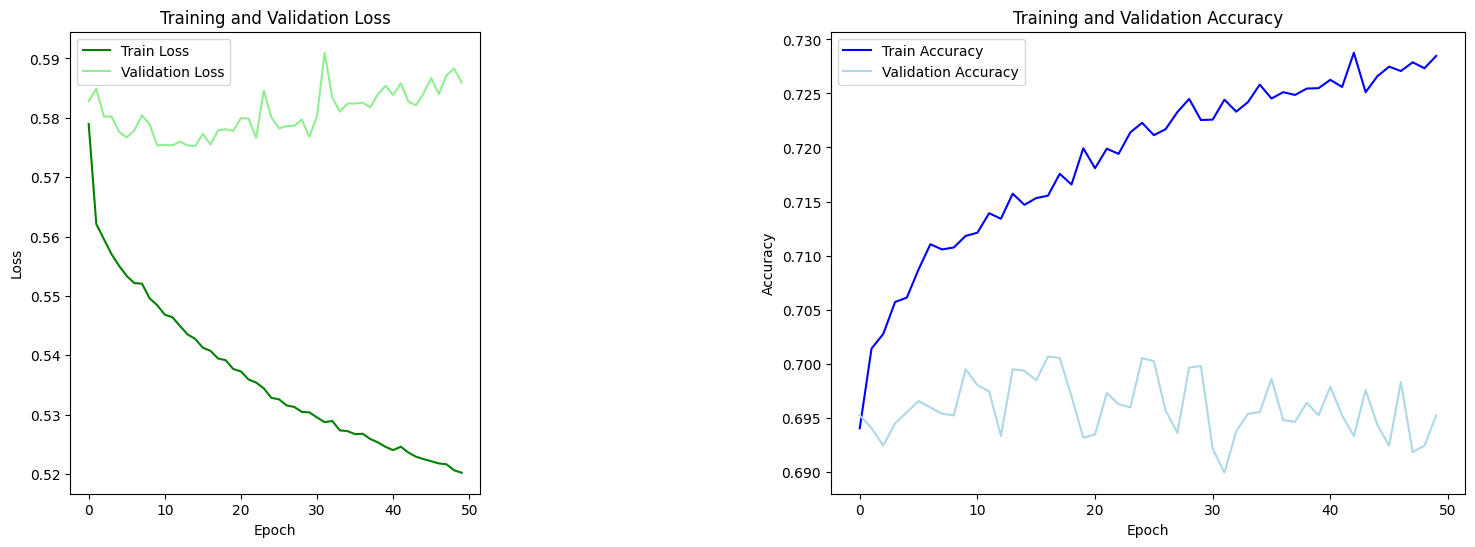

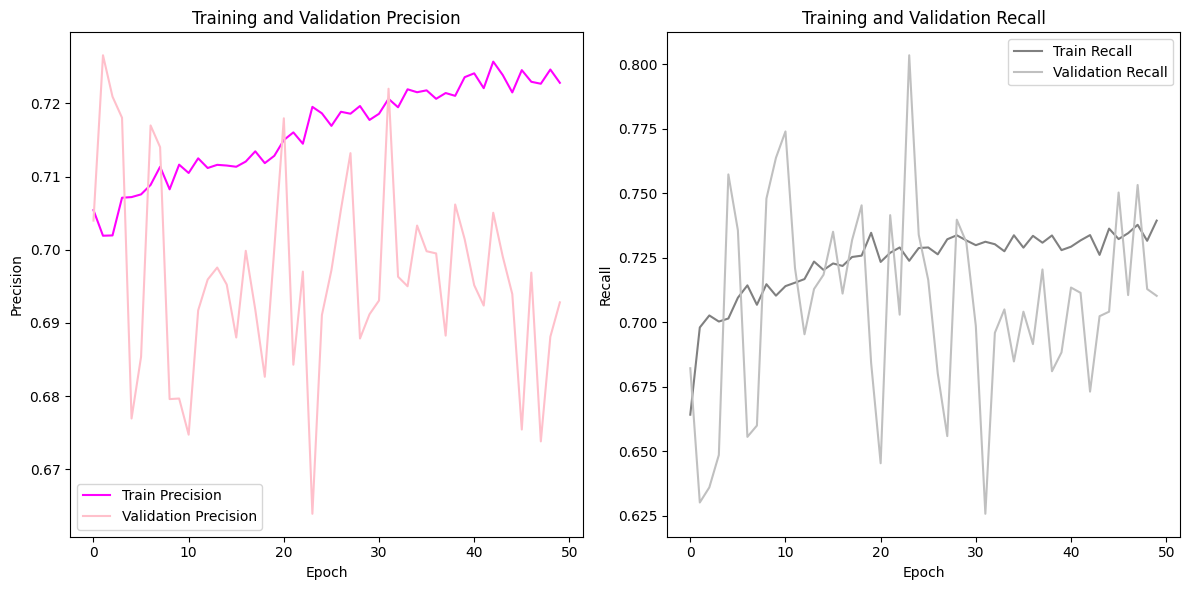

In [0]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del entrenamiento y la validación desde history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

recall = history.history['recall_4']
val_recall = history.history['val_recall_4']

precision = history.history['precision_4']
val_precision = history.history['val_precision_4']


# Crear gráficos
plt.figure(figsize=(18, 6))

# Gráfico de pérdida
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train Loss', color='green')
plt.plot(val_loss, label='Validation Loss', color='lightgreen')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='lightblue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Crear gráficos
plt.figure(figsize=(12, 6))

#Grafico de precisión
plt.subplot(1, 2, 1)
plt.plot(precision, label='Train Precision', color='Magenta')
plt.plot(val_precision, label='Validation Precision', color='pink')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Gráfico de accuracy
plt.subplot(1, 2, 2)
plt.plot(recall, label='Train Recall', color='Gray')
plt.plot(val_recall, label='Validation Recall', color='Silver')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.tight_layout()
plt.show()



## ML Flow

Esto es lo que estaba en el taller y debo adaptarlo para ML flow

In [0]:
from keras.models import load_model
# defina el servidor para llevar el registro de modelos y artefactos
# mlflow.set_tracking_uri('http://localhost:5000')
# Verificar el número de características después del preprocesamiento
input_dim = X_test_preprocessed.shape[1]
print(f"Número de características después del preprocesamiento: {input_dim}")

# registre el experimento
experiment_name = "/Users/s.dazac@uniandes.edu.co/Databricks"
experiment = mlflow.set_experiment(experiment_name)

mlflow.end_run()

with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Procesar los datos
    X_train_preprocessed = pipeline.transform(X_train)
    X_test_preprocessed = pipeline.transform(X_test)

    #Definir el modelo
    model = Sequential([
        Dense(60, input_dim=input_dim, activation='relu'),
        Dense(60, activation='relu'),
        Dense(40, activation='relu'),
        Dense(40, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'binary_crossentropy'])

    # Entrenar el modelo
    history = model.fit(X_train_preprocessed, y_train, epochs=50,
                       validation_data=(X_test_preprocessed, y_test))

    # Realizar predicciones
    predictions = model.predict(X_test_preprocessed)
    predicted_classes = (predictions > 0.6).astype(int)

    #Matriz de confusión
    cm = confusion_matrix(y_test, predicted_classes)

    # Calcular las métricas derivadas de la matriz de confusión
    precision = precision_score(y_test, predicted_classes)
    recall = recall_score(y_test, predicted_classes)
    f1 = f1_score(y_test, predicted_classes)
    mse = mean_squared_error(y_test, predictions)

    # Registrar los parámetros que se ajustan
    mlflow.log_param("optimizer", "Adam") #Adam
    mlflow.log_param("learning_rate", 0.001) #0.001
    mlflow.log_param("epochs", 50)
    mlflow.log_param("num_hidden_layers", 4) #4
    mlflow.log_param("hidden_layer_units", [40, 40, 20, 20]) #30,15,10,5
    # mlflow.log_param("dropout_rate", )

    # Registrar el modelo
    mlflow.keras.log_model(model, "neural-network-model")

    # Registrar las métricas
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mse", mse)

    # Registrar otras métricas del historial de entrenamiento
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])

    print(f"MSE: {mse}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{cm}")

Número de características después del preprocesamiento: 43
Epoch 1/50


/databricks/python/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


849/849 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6769 - binary_crossentropy: 0.5931 - loss: 0.5931 - precision_20: 0.6894 - recall_20: 0.6008 - val_accuracy: 0.6949 - val_binary_crossentropy: 0.5781 - val_loss: 0.5820 - val_precision_20: 0.7172 - val_recall_20: 0.6518
Epoch 2/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7055 - binary_crossentropy: 0.5584 - loss: 0.5584 - precision_20: 0.7162 - recall_20: 0.6791 - val_accuracy: 0.6961 - val_binary_crossentropy: 0.5745 - val_loss: 0.5785 - val_precision_20: 0.6805 - val_recall_20: 0.7485
Epoch 3/50
127/849 ━━

*** WARNING: max output size exceeded, skipping output. ***

849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7537 - binary_crossentropy: 0.4681 - loss: 0.4681 - precision_20: 0.7553 - recall_20: 0.7482 - val_accuracy: 0.6945 - val_binary_crossentropy: 0.6593 - val_loss: 0.6637 - val_precision_20: 0.7049 - val_recall_20: 0.6775
Epoch 49/50
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7514 - binary

2024/05/29 02:55:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/05/29 02:55:54 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.13.0, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/29 02:55:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

2024/05/29 02:55:54 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


MSE: 0.20148924344376531
Precision: 0.7366863905325444
Recall: 0.5824561403508772
F1 Score: 0.65055519268452
Confusion Matrix:
[[2653  712]
 [1428 1992]]


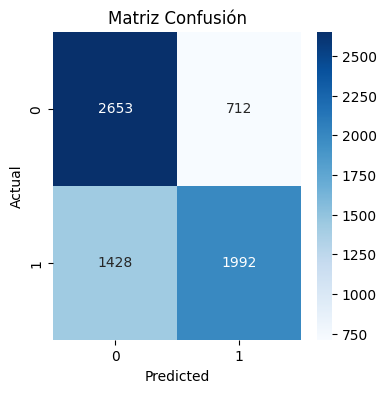

In [0]:
import seaborn as sns
#Gráfico de la matriz de confusión
plt.figure(figsize=(4, 4)) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])  # Heatmap
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz Confusión")
plt.show()

In [0]:
# Calculando las medidas
TP = cm[0,0]  # Verdaderos negativos (cuando la clase sea 0)
FP = cm[0,1]  # Falsos positivos
FN = cm[1,0]  # Falsos negativos
TN = cm[1,1]  # Verdaderos positivos

# Sensibilidad (Recall)
sensibilidad = round(TP / (TP + FN),2)

# Especificidad
especificidad = round(TN / (TN + FP),2)

#TO-DO: Calcular la precisión y la exactitud, redondear a dos decimales
precision = round(TP/(TP+FP),2)
exactitud = round((TP+FP)/(TN+FN+TP+FP),2)

f1=round(2*precision*sensibilidad/(precision + sensibilidad),2)

print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad:", especificidad)
print("Precisión:", precision)
print("Exactitud (Accuracy):", exactitud)
print("F Score:", f1)

Sensibilidad (Recall): 0.65
Especificidad: 0.74
Precisión: 0.79
Exactitud (Accuracy): 0.5
F Score: 0.71
